In [1]:
#Atributos para Twitter
from twikit import Client, TooManyRequests
from configparser import ConfigParser

#Funciones extra
import time
import os
from datetime import datetime
from random import randint
import neattext.functions as nfx
import chardet

#Modelo para sentimiento
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

#Generación de gráficos y dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import STOPWORDS

#Generación de mapa de calor
from geopy.geocoders import Nominatim
import gmplot

c:\Users\USER_1\Desktop\VSCodes\twitter-extraction\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Logueo en Twitter (X)

In [ ]:
config = ConfigParser()
config.read('config.ini')

#Credenciales
username = config['X']['username']
email = config['X']['email']
password = config['X']['password']

#Localización
latitud = config['LOCATION']['latitude']
longitud = config['LOCATION']['longitude']
radio = config['LOCATION']['radius']

tweets_csv = {'ID': [], 'Fecha': [], 'Usuario': [], 'Contenido': [], 'Localización': [], 'URL': [], 'Seguidores': [], 'Retweets': [], 'Likes': [], 'Sentimiento': []}

client = Client(language='es')
#await client.login(auth_info_1=username, auth_info_2=email, password=password)
#client.save_cookies('cookies.json')

client.load_cookies('cookies.json')

Evitando texto erróneo (caracteres raros)

In [6]:
def clean_text(text):
    try:
        #Codificación original del texto
        detected_encoding = chardet.detect(text.encode())['encoding']
        
        #Conversión necesaria a UTF-8
        if detected_encoding:
            text = text.encode(detected_encoding).decode('utf-8')
                
    except Exception as e:
        print(f"Error al procesar el texto: {text} - {e}")
    
    return text

Solicitud de tweets y conteo

In [7]:
MINIMUN_TWEETS = 100

tweet_count = 0
tweets = None

Scrappeo de tweets (cliente + carga)

In [8]:
async def get_tweets(tweets, anio, mes):
    #Búsqueda avanzada
    QUERY = f'línea uno metro lima (ATU OR gobierno OR servicio OR demora OR tiempo OR perú OR lima OR tren OR uno OR linea OR uno) lang:es geocode:{latitud},{longitud},{radio} until:{anio}-{mes}-31 since:{anio}-{mes}-01'

    if tweets is None:
        print(f'{datetime.now()} - Obteniendo tweets...')
        tweets = await client.search_tweet(QUERY, product='Top')
    else:
        wait_time = randint(1, 3)
        print(f'{datetime.now()} - Obteniendo siguientes tweets en {wait_time} segundo(s)...')
        time.sleep(wait_time)
        tweets = await tweets.next()
    
    return tweets

Uso del modelo BERT

In [9]:
MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
ROBERTA_SUPPORTED_LANGUAGES = ('ar', 'en', 'fr', 'de', 'hi', 'it', 'sp', 'pt')
ROBERTA_SUPPORTED_LANGUAGES = [lang.lower() for lang in ROBERTA_SUPPORTED_LANGUAGES]

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

In [10]:
#model.save_pretrained(MODEL)
#tokenizer.save_pretrained(MODEL)

Calificación del texto (sentimiento)

In [11]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

def predict_sentiment(text: str) -> str:
    processed_text = preprocess(text)
    encoded_input = tokenizer(processed_text, return_tensors='pt')
    output = model(**encoded_input)
    index_of_sentiment = output.logits.argmax().item()
    sentiment = config.id2label[index_of_sentiment]

    return sentiment

Periodo de tiempo establecido

In [12]:
meses = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
anio = '2024'

Extracción completa y detallada

In [13]:
for m in meses:
    while tweet_count < MINIMUN_TWEETS:
        #Solicitudes con espera
        try:
            tweets = await get_tweets(tweets, anio, m)
        except TooManyRequests as e:
            rate_limit_reset = datetime.fromtimestamp(e.rate_limit_reset)
            print(f'{datetime.now()} - Rate limit reached. Waiting unitl {rate_limit_reset}')
            wait_time = rate_limit_reset - datetime.now()
            time.sleep(wait_time.total_seconds())
            continue

        if not tweets:
            print(f'{datetime.now()} - No más tweets')
            break

        for tweet in tweets:
            #Guardar tweets solo Lima - Perú
            cond1 = any(w in tweet.user.location.lower() for w in ("lima", "perú", "peru"))
            cond2 = tweet.id not in tweets_csv['ID']

            #Formateo de fechas
            fecha = datetime.strptime(tweet.created_at, "%a %b %d %H:%M:%S %z %Y")
            cond3 = (fecha.year == int(anio))

            if (cond1 and cond2 and cond3):
                tweet_count += 1

                #Llenado de diccionario
                tweets_csv['ID'].append(tweet.id)

                fecha = fecha.strftime("%Y-%m-%d %H:%M:%S")
                tweets_csv['Fecha'].append(fecha)

                tweets_csv['Usuario'].append(tweet.user.name)
                tweets_csv['Contenido'].append(tweet.text)
                tweets_csv['Localización'].append(tweet.user.location)

                url = 'https://x.com/' + tweet.user.screen_name + '/status/' + tweet.id
                tweets_csv['URL'].append(url)

                tweets_csv['Seguidores'].append(tweet.user.followers_count)
                tweets_csv['Retweets'].append(tweet.retweet_count)
                tweets_csv['Likes'].append(tweet.favorite_count)

                #Asignación de sentimiento
                sentiment = predict_sentiment(tweet.text)
                tweets_csv['Sentimiento'].append(sentiment)
                    
        print(f'{datetime.now()} - Obtenidos {tweet_count} tweets')

    tweet_count = 0
    tweets = None
            
    print(f"-> Extraído del mes {m}")

print(f"Extracción finalizada, se extrajeron {len(tweets_csv['ID'])} tweets")

2024-12-10 08:31:47.920619 - Obteniendo tweets...
2024-12-10 08:31:50.054098 - Obtenidos 6 tweets
2024-12-10 08:31:50.054098 - Obteniendo siguientes tweets en 1 segundo(s)...
2024-12-10 08:31:53.586894 - Obtenidos 16 tweets
2024-12-10 08:31:53.587894 - Obteniendo siguientes tweets en 3 segundo(s)...
2024-12-10 08:31:59.225165 - Obtenidos 28 tweets
2024-12-10 08:31:59.225165 - Obteniendo siguientes tweets en 1 segundo(s)...
2024-12-10 08:32:02.379875 - Obtenidos 37 tweets
2024-12-10 08:32:02.379875 - Obteniendo siguientes tweets en 3 segundo(s)...
2024-12-10 08:32:07.010921 - Obtenidos 43 tweets
2024-12-10 08:32:07.011919 - Obteniendo siguientes tweets en 1 segundo(s)...
2024-12-10 08:32:08.697298 - Obtenidos 44 tweets
2024-12-10 08:32:08.697298 - Obteniendo siguientes tweets en 1 segundo(s)...
2024-12-10 08:32:10.202637 - No más tweets
-> Extraído del mes 01
2024-12-10 08:32:10.202637 - Obteniendo tweets...
2024-12-10 08:32:13.065282 - Obtenidos 13 tweets
2024-12-10 08:32:13.065282 - O

Creación del dataset

In [ ]:
df = pd.DataFrame(tweets_csv)
df.sort_values(by='Likes', inplace=True, ascending=False)

# Quitar saltos de línea y espacios en blanco de las columnas de texto
df['Contenido'] = df['Contenido'].str.replace('\n', ' ', regex=True).str.strip()
df['Localización'] = df['Localización'].str.replace('\n', ' ', regex=True).str.strip()

#Limpieza de textos
df['Contenido'] = df['Contenido'].apply(nfx.remove_urls)
df['Contenido'] = df['Contenido'].apply(nfx.remove_multiple_spaces)
df['Contenido'] = df['Contenido'].apply(nfx.remove_emojis)
#df['Contenido'] = df['Contenido'].apply(clean_text)
df['Usuario'] = df['Usuario'].apply(clean_text)

#Creado y guardado de csv
file_path = os.path.join('src', 'files', 'tweets_final.csv')
df.to_csv(file_path, sep=';', index=False)

Error al procesar el texto: Jaime Serra 🇵🇪 - 'charmap' codec can't encode characters in position 12-13: character maps to <undefined>
Error al procesar el texto: Juan Pablo León 🇵🇪 - 'charmap' codec can't encode character '\xf3' in position 13: character maps to <undefined>
Error al procesar el texto: Juan Pablo León 🇵🇪 - 'charmap' codec can't encode character '\xf3' in position 13: character maps to <undefined>
Error al procesar el texto: Pamela Acosta ☕📰 - 'charmap' codec can't encode characters in position 14-15: character maps to <undefined>
Error al procesar el texto: Rodolfo Pérez - 'utf-8' codec can't decode byte 0xe9 in position 9: invalid continuation byte
Error al procesar el texto: Juan Pablo León 🇵🇪 - 'charmap' codec can't encode character '\xf3' in position 13: character maps to <undefined>
Error al procesar el texto: Juan Pablo León 🇵🇪 - 'charmap' codec can't encode character '\xf3' in position 13: character maps to <undefined>
Error al procesar el texto: Juan Pablo León 

Estudio del dataset

In [ ]:
df.head()

,ID,Fecha,Usuario,Contenido,Localización,URL,Seguidores,Retweets,Likes,Sentimiento
56,1847703750586020291,2024-10-19 18:17:57,Katya Adaui,No volvía a Lima desde enero. Qué inhabitable:...,Una peruana en Buenos Aires,https://x.com/kadaui/status/1847703750586020291,16163,402,3152,negative
207,1824488521857396761,2024-08-16 16:48:55,Crookez,"Claro, porque te demoras 2 horas en llegar y 4...",Peru 🇵🇪,https://x.com/crooknuke/status/182448852185739...,3133,477,3141,negative
246,1850665299223498767,2024-10-27 22:26:05,Carlos Bruce - Techito,¡NO SEÑOR LOPEZ ALIAGA! NO NOS OPONEMOS AL PRO...,"Lima, Perú",https://x.com/Carlos_Bruce/status/185066529922...,108149,629,3108,negative
197,1828927171601092721,2024-08-28 22:46:32,Jaime Serra 🇵🇪,Llamé a @ClaroPeru me respondió una operadora ...,"Lima, Perú",https://x.com/JaimeSerra/status/18289271716010...,4311,1247,2932,negative
17,1748460655168892972,2024-01-19 21:41:19,Juan Pablo León 🇵🇪,Chile ya está al nivel de Londres en transport...,"Lima, Perú",https://x.com/mal_menor/status/174846065516889...,58816,754,2777,neutral


In [ ]:
df.columns

Index(['ID', 'Fecha', 'Usuario', 'Contenido', 'Localización', 'URL',
       'Seguidores', 'Retweets', 'Likes', 'Sentimiento'],
      dtype='object')

In [ ]:
data_df = df.drop(['ID', 'Fecha', 'Usuario', 'Localización', 'URL', 'Seguidores', 'Retweets', 'Likes'], axis=1)
data_df.head()

,Contenido,Sentimiento
56,No volvía a Lima desde enero. Qué inhabitable:...,negative
207,"Claro, porque te demoras 2 horas en llegar y 4...",negative
246,¡NO SEÑOR LOPEZ ALIAGA! NO NOS OPONEMOS AL PRO...,negative
197,Llamé a @ClaroPeru me respondió una operadora ...,negative
17,Chile ya está al nivel de Londres en transport...,neutral


Gráficos estadísticos

<Axes: xlabel='Sentimiento', ylabel='count'>

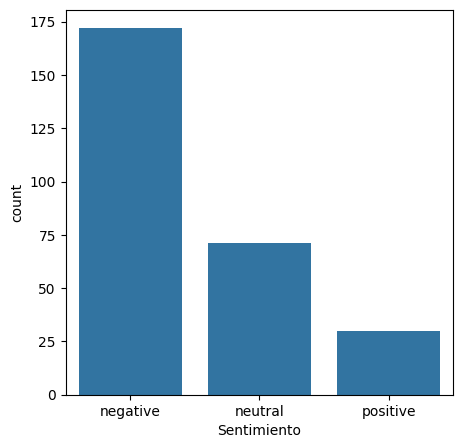

In [ ]:
#Gráfico de barras
fig = plt.figure(figsize=(5,5))
sns.countplot(x='Sentimiento',data=data_df)

Text(0.5, 1.0, 'Distribucion de sentimientos')

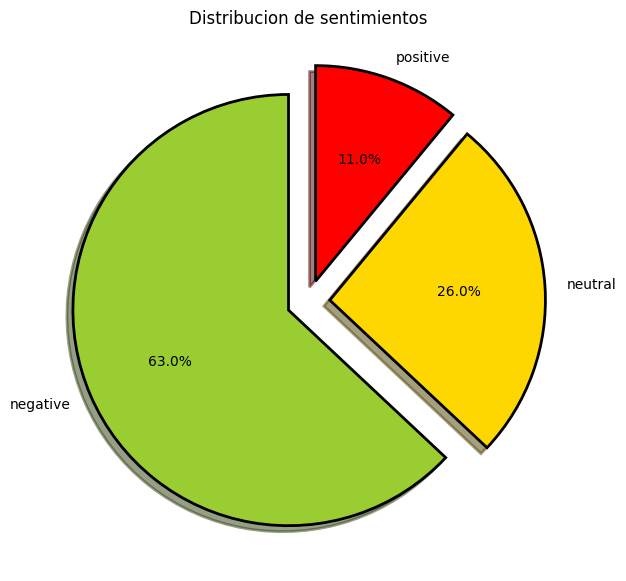

In [ ]:
#Gráfico de pastel
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}

#Fuente de datos
tags = data_df['Sentimiento'].value_counts()

explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')

plt.title("Distribucion de sentimientos")

Quitar palabras que no aportan valor

In [ ]:
stopwords_es = set(STOPWORDS).union({
    'de', 'que', 'y', 'en', 'la', 'el', 'los', 'las', 'con', 'por', 'para', 
    'una', 'un', 'es', 'al', 'lo', 'como', 'más', 'a', 'se', 'del', 'o', 
    'sin', 'sus', 'le', 'ha', 'este', 'su', 'no', 'muy', 'me', 'si', 'pero', 
    'ya', 'todo', 'también', 'fue', 'entre', 'sobre', 'ser', 'hay', 'cuando',
    'son', 'estos', 'nos', 'ni', 'eso', 'algo', 'hasta', 'está', 'qué', 'día',
    'han', 'va', 'e', 'S', 'http', 'https'
})

Palabras más frecuentes por sentimiento

In [ ]:
def panel_wordcloud(data_df, sentiment):
    #Para todos los sentimientos
    words_tweets=data_df[data_df['Sentimiento']==sentiment]
    words_tweets.head() #Muestra parte de lo tomado

    if len(words_tweets)!=0:
        text = ' '.join([word for word in words_tweets['Contenido']])
        plt.figure(figsize=(20,15), facecolor='None')

        wordcloud = WordCloud(max_words=500, width=1600, height=800, stopwords=stopwords_es).generate(text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Palabras mas frecuentes en tweets ({sentiment})", fontsize=19)
    else:
        print("No hay datos para analizar")

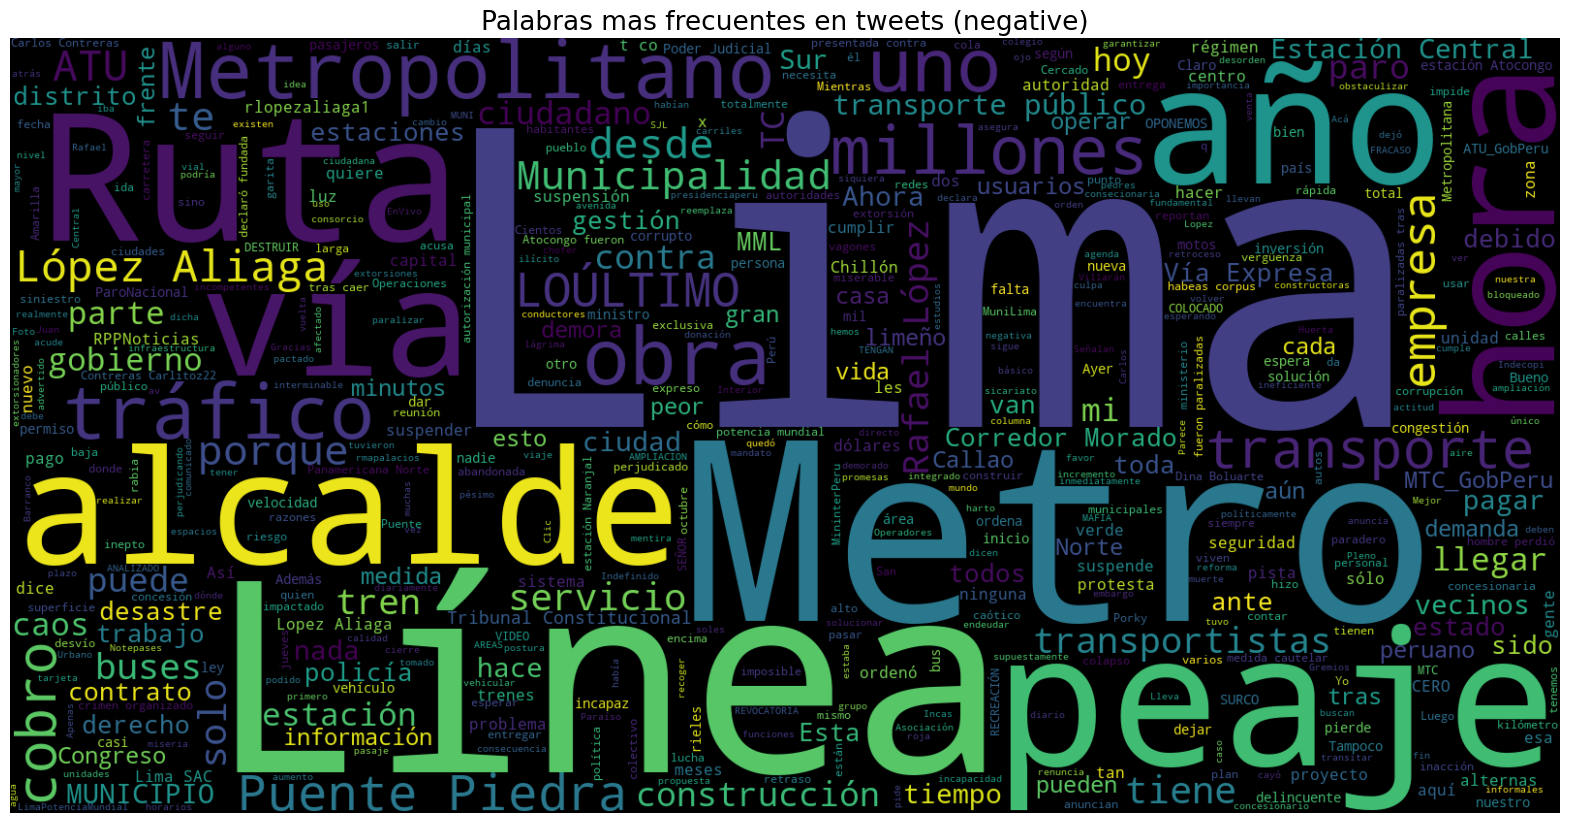

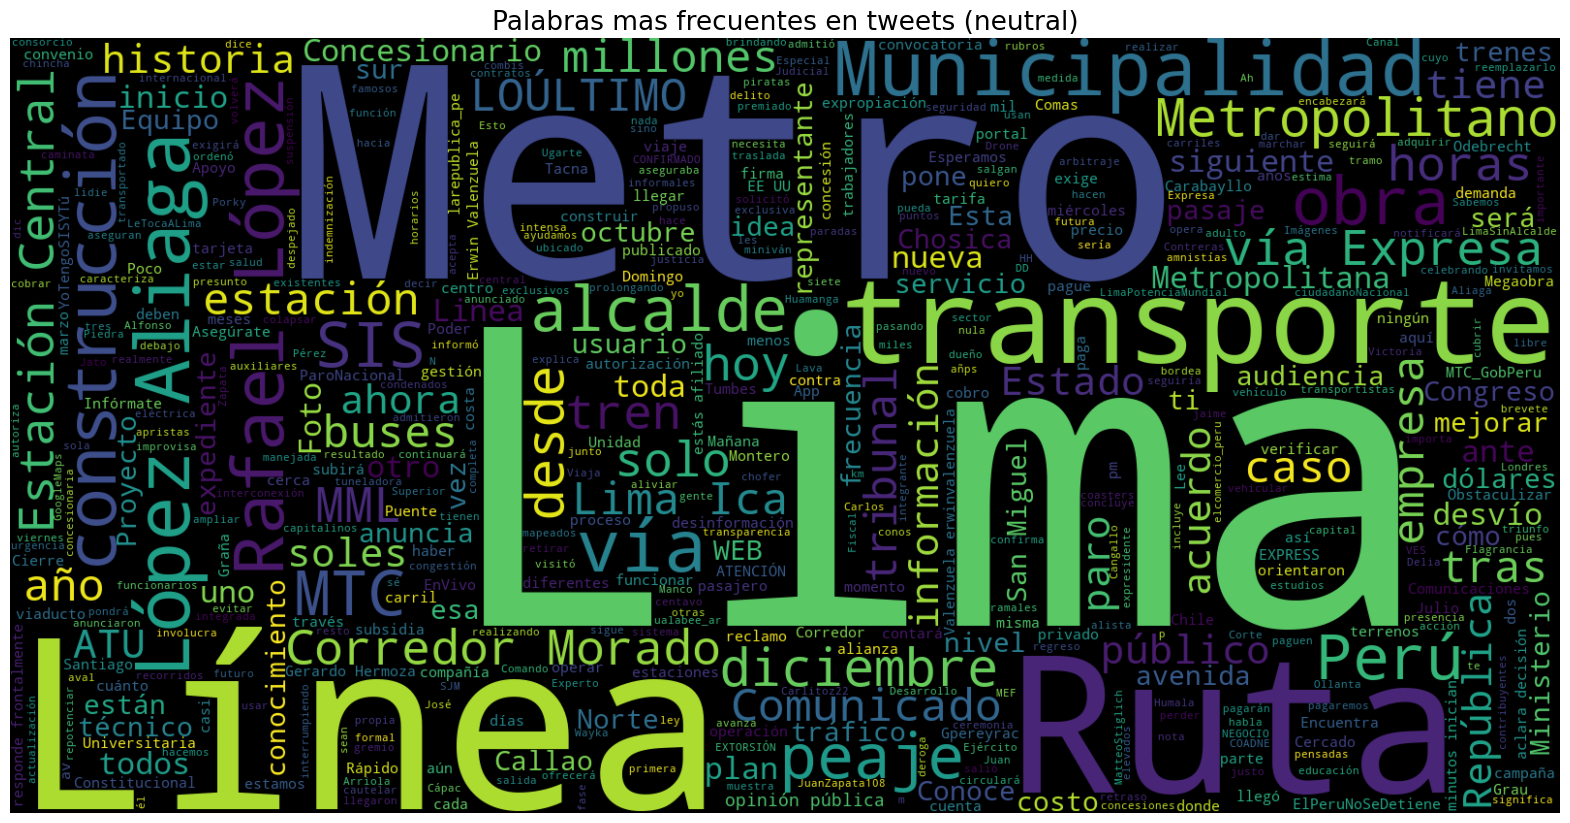

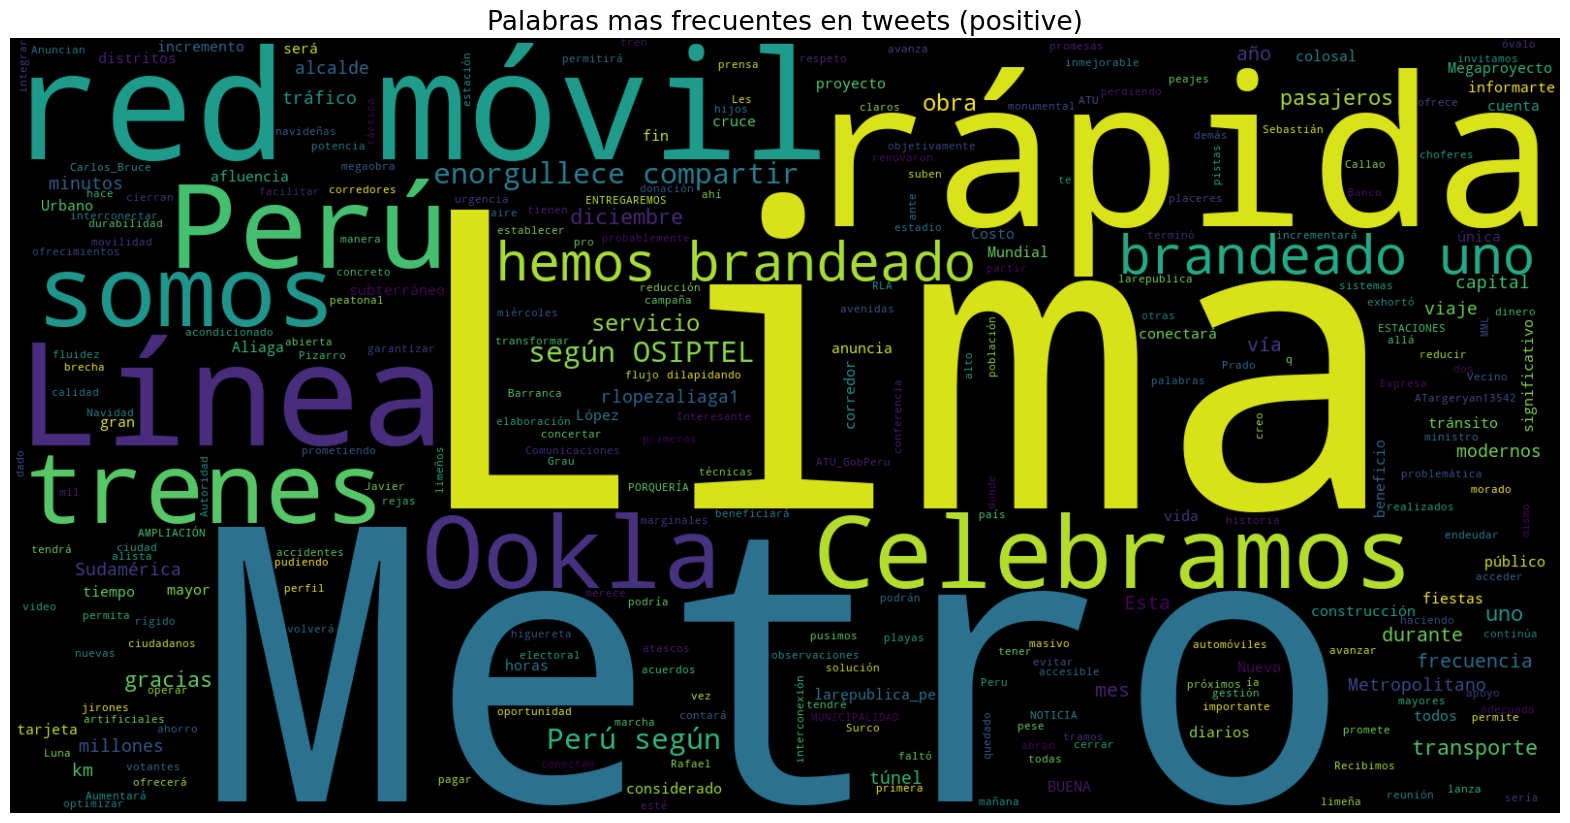

In [ ]:
sentiments = ["negative", "neutral", "positive"]

for value in sentiments:
    panel_wordcloud(data_df, value)

Mapa de Calor

In [ ]:
geolocator = Nominatim(user_agent="BD-CR-APP")

#Diccionario de coordenadas
coordenadas = {'latitud': [], 'longitud': []}

In [ ]:
for user in enumerate(tweets_csv['Localización']):
    try:
        location = geolocator.geocode(user)

        #Recolección de ubicación
        if location:
            coordenadas['latitud'].append(location.latitude)
            coordenadas['longitud'].append(location.longitude)
    #Para un exceso de solicitudes
    except Exception as e:
        print(f"Excepción encontrada: {e}")
        pass

In [ ]:
#Centrar objeto GoogleMapPlotter para mostrar mapa de Lima
gmap = gmplot.GoogleMapPlotter(-12.0464, -77.0428, 12)

#Insertar puntos en el mapa con lista de latitudes y longitudes
gmap.heatmap(coordenadas['latitud'], coordenadas['longitud'], radius=20)

file_map = os.path.join('src', 'files', 'tweets_heatmap.html')
gmap.draw(file_map)
print("Mapa de calor creado con exito")

Mapa de calor creado con exito
